# Statistical Inference on Price of Airbnb Listings Given Property Type and Cancellation Policy
Group 39
## Introduction
Home-sharing sites like Airbnb have seen substantial development in the last decade, with its ever-expanding user base attracting more customers every day. As these platforms grow in popularity, their influence on the hotel industry is becoming more and more apparent. Airbnb, for example, currently has more listings than the top five hotel firms in the world combined (Hartmans, 2017), demonstrating the home-sharing boom's market dominance. As a result, homeowners are realizing that Airbnb is a profitable method to monetize properties that might otherwise be left unoccupied, making the identification of favorable property types useful for decision-making among many stakeholders, including real estate agents, homebuyers, and property owners.

Given this trend, it is critical for both hosts and guests to understand the elements that influence the price of an Airbnb listing. Airbnb has swiftly gained popularity as a lodging option for travelers all around the world, and understanding these aspects is crucial for optimizing the hosting and booking experience. In this project, we will use R to examine the relationship between property types, cancellation restrictions, and their influence on the natural log price of listings by investigating an Airbnb dataset from Kaggle. Our main purpose in analyzing the data is to determine if there are statistically significant differences in the mean log prices of various property types and cancellation policies.

We believe that our study will be useful and valuable to property owners contemplating offering their houses on Airbnb, as well as real estate agents and homebuyers wanting to invest in properties with potential for higher income. Stakeholders may make better informed and more educated decisions in the ever-changing home-sharing industry by better understanding the link between property types and listing prices.




## Methods and Results
### Are Apartment-type properties cheaper than House-type properties on Airbnb?


For this section, we define notations as follows:

- $\mu_h =$  population mean log price of House type listings

- $\mu_a =$ population mean log price of Apartment type listings



In [85]:
# load packages
library(tidyverse)
library(tidymodels)
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(broom)
library(digest)
library(grid)
library(gridExtra)

### Preliminary Analysis
First, we should perform some preliminary analysis on the data.

In [86]:
# read data
set.seed(320)
Airbnb_whole <- read.csv("https://raw.githubusercontent.com/takumihoriba/stat201-project/stat201/data/train.csv") 


In [87]:
print("Table 1: Raw data set") 
head(Airbnb_whole, 4)

[1] "Table 1: Raw data set"


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,⋯,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Essentials,""Hair dryer"",Iron,""translation missing: en.hosting_amenity_50""}",3,1,Real Bed,strict,True,⋯,40.69652,-73.99162,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100,https://a0.muscache.com/im/pictures/6d7cbbf7-c034-459c-bc82-6522c957627c.jpg?aki_policy=small,11201,1,1
2,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Washer,Dryer,""Smoke detector"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""translation missing: en.hosting_amenity_50""}",7,1,Real Bed,strict,True,⋯,40.76612,-73.98904,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93,https://a0.muscache.com/im/pictures/348a55fe-4b65-452a-b48a-bfecb3b58a66.jpg?aki_policy=small,10019,3,3
3,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air conditioning"",Kitchen,Breakfast,""Buzzer/wireless intercom"",Heating,""Family/kid friendly"",""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_50""}",5,1,Real Bed,moderate,True,⋯,40.80811,-73.94376,The Garden Oasis,Harlem,10,92,https://a0.muscache.com/im/pictures/6fae5362-9e3a-4fa9-aa54-bbd5ea26538d.jpg?aki_policy=small,10027,1,3
4,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Kitchen,""Indoor fireplace"",""Buzzer/wireless intercom"",Heating,Washer,Dryer,""Smoke detector"",""Carbon monoxide detector"",""First aid kit"",""Fire extinguisher"",Essentials}",4,1,Real Bed,flexible,True,⋯,37.77200,-122.43162,Beautiful Flat in the Heart of SF!,Lower Haight,0,NA,https://a0.muscache.com/im/pictures/72208dad-9c86-41ea-a735-43d933111063.jpg?aki_policy=small,94117.0,2,2


Here, we clean and wrangle the dataset into a tidy format. Since our dataset is too big for our student server to create bootstrap samples, we randomly choose a subset of this dataset of size 10,000. This allows us to perform analysis more smoothly while maintaining reasonable accuracy.

In [88]:
set.seed(320)

Airbnb <- Airbnb_whole |>
        rep_sample_n(size = 10000,reps=1,replace=FALSE) |>
        ungroup() |>
        select(-replicate)

Airbnb_tidy <- Airbnb |>
        select(log_price, property_type) |>
        filter(property_type %in% c("House", "Apartment"))

print("Table 2: Tidy form dataset") 
head(Airbnb_tidy)

[1] "Table 2: Tidy form dataset"


log_price,property_type
<dbl>,<chr>
4.094345,House
4.700480,House
4.477337,House
6.395262,House
5.521461,Apartment
3.178054,House


### Inference on mean log price given the two property types, House and Apartment

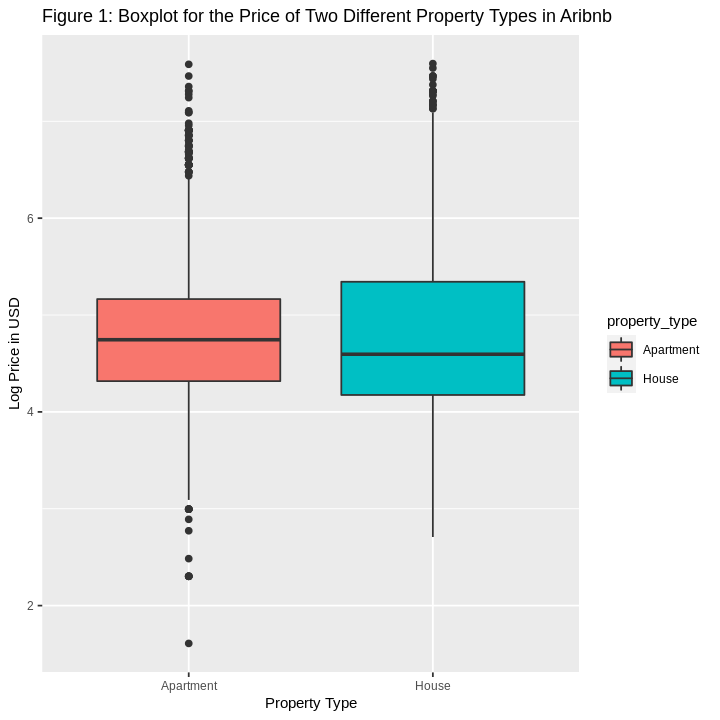

In [89]:
#create boxplot for the Log Price for two different property types (House and Apartment)
#(explanatory variable is property type and response variable is the log price)
set.seed(320)
options(repr.plot.width = 6, repr.plot.height = 6)
log_price_boxplot <- ggplot(Airbnb_tidy,aes(x=property_type,y=log_price, fill = property_type))+
                     geom_boxplot()+
                     labs(x="Property Type",y="Log Price in USD") +
                     theme(text=element_text(size=9))+
                     labs(title="Figure 1: Boxplot for the Price of Two Different Property Types in Aribnb")
log_price_boxplot



In [90]:
#Preliminary exploratory data analysis
#Calculate the percentage of each type of property (House and Apartment) in the dataset
set.seed(320)
prop_house_apartment <- Airbnb_tidy |>
group_by(property_type) |>
summarize(percent =  n()/nrow(Airbnb_tidy )) |>
arrange(desc(percent))
print("Table 3: the proportion of the property type") 
prop_house_apartment

[1] "Table 3: the proportion of the property type"


property_type,percent
<chr>,<dbl>
Apartment,0.7482297
House,0.2517703


In [91]:
#estimate the parameter
#calculate the mean, sd, min and max value for each property type 
set.seed(320)
Airbnb_summary <- Airbnb_tidy |> group_by(property_type)|> summarize(mean = mean(log_price),sd=sd(log_price),var=var(log_price),
                                                                     min=min(log_price), max=max(log_price),n=n())
print("Table 4: Data Summary") 
Airbnb_summary

[1] "Table 4: Data Summary"


property_type,mean,sd,var,min,max,n
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Apartment,4.760592,0.6415739,0.4116170,1.609438,7.588324,6657
House,4.798602,0.8887712,0.7899142,2.708050,7.595890,2240


### Two-sample T-test

After that, we chose a two-sample t-test to test our hypothesis and check whether there is a statistically significant difference between the mean log prices of House and Apartment listings. We used a two-sample t-test with a significance level of 5%. 

To perform this hypothesis test, we split the dataset (`Airbnb_tidy`) into two independent samples (based on `property_type`: "House", "Apartment"), and then use the function `t.test` to perform hypothesis testing (in our hypothesis we chose the order u_House-u_Apartment, so to maintain consistency in `t.test`, we set x to House and y to Apartment), and use `broom::tidy()` to organize the results.

In [92]:
# Execute two-sample t-test
set.seed(320)
apartment <- Airbnb_tidy |>
             filter(property_type=="Apartment")|>
             select(log_price)
house <- Airbnb_tidy |>
             filter(property_type=="House")|>
             select(log_price)
two_sample_t_test <- tidy(
                          t.test(x = house,
                                 y = apartment,
                                 alternative = "greater"))
print("Table 5: Results of the t-test") 
two_sample_t_test

[1] "Table 5: Results of the t-test"


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.03800942,4.798602,4.760592,1.866996,0.03099884,3061.352,0.004512368,Inf,Welch Two Sample t-test,greater


With the above formula, we obtain a p-value of 0.03099884 (about 3%), and since we chose a 5% significance level, we can conclude that we have sufficient evidence to reject the null hypothesis—the test is significant at the given 5% level. We conclude that there is sufficient evidence that the true population parameter $\mu_h - \mu_a$ is significantly larger than the specified value 0.

### Bootstrapping

In addition to the above method, we chose to use bootstrapping to construct the hypothesis test, choosing a 95% confidence interval since the significance level we chose in the t-test was 5%. 

We chose the workflow in the `infer` package for bootstrapping to obtain a 95% confidence interval for the test statistic to test the hypothesis. We set the response variable as `log_price`, and the explanatory variable as `property_type`. Since we have two independent samples (Apartment and House), we set our null hypothesis to "independence". We chose 1000 reps as a reasonable compromise between representation accuracy and calculation time on our student servers. Then we compute the test statistic, our `diff in means`, in the order of c("House", "Apartment"), and finally, obtain a 95% confidence interval for the true value of the test statistic, the true difference in means of log price between House and Apartment listings on Airbnb.

In [93]:
set.seed(320) 
# get the confidence interval by bootstrapping (using infer package)

bootstrapping  <- Airbnb_tidy |>
                  specify(formula = log_price ~ property_type)  %>%
                  hypothesize(null = "independence") %>%
                  generate(reps = 1000, type = "bootstrap") %>%
                  calculate(stat = "diff in means", order = c("House", "Apartment")) |>
                  get_ci(level = 0.95)

print("Table 6: Confidence Interval (Bootstrapping)") 
bootstrapping

[1] "Table 6: Confidence Interval (Bootstrapping)"


lower_ci,upper_ci
<dbl>,<dbl>
0.0003727622,0.07812131


We obtain a 95% confidence interval of [0.0003727622 0.07812131], which indicates that we are 95% confident that the the value of $\mu_h - \mu_a$ is within that interval. Since $\mu_h - \mu_a = 0$ is not within this range, we have sufficient evidence to reject the null hypothesis at the significance level of 5%.


### Comparing bootstrapping and asymptotics

When we compared the ranges of the two confidence intervals, we found that the range of the 95% confidence interval derived by the bootstrap method is 0.07774855, while the range of the 95% confidence interval derived by the asymptotic method is infinity—much larger than the confidence interval derived by the bootstrap method. For the same sample at the same confidence level, the smaller the confidence interval range, the more accurate and appropriate it is. 
This difference does not affect this particular analysis. However, this may cause a discrepancy if the data itself, significance level, sample size or other factors change. In summary, we think the bootstrap method is more credible than the asymptotic method for this particular situation. 

### Inference on mean log price given different cancellation policies through Analysis of Variance
Secondly, we perform analysis of variance on price based on different cancellation policies. The variable `cancellation_policy` represents a level of flexibility for cancellation for a listing, and we will utilize this categorical variable which divides the sample into five different groups to conduct a hypothesis test on mean prices from each group. Our null hypothesis is that all the mean log prices are equal, and the alternative hypothesis is that at least one of the mean log prices is different from the others. We will employ ANOVA as we know there are more than 2 possible cancellation policies, and thus groups of data, inside the `cancellation_policy` variable. 

We would like to check if there is already a notable difference in prices by creating a boxplot, since it allows us to see the conditional distributions of price given the cancellation policy. The Figure 2 shows an overall trend that as the cancellation policy becomes stricter, the price gets higher.

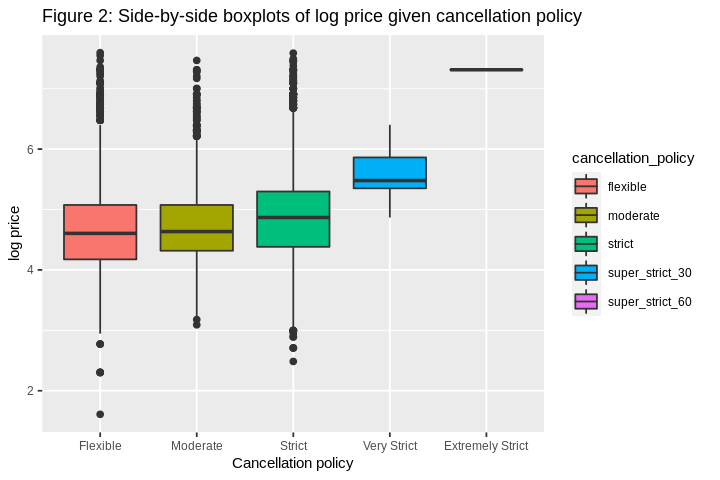

In [94]:
# Comparison of mean log prices given cancellation policy
options(repr.plot.width = 6, repr.plot.height = 4)


bp <- Airbnb |>
    ggplot(aes(x = cancellation_policy, y = log_price, fill = cancellation_policy)) +
    geom_boxplot() +
    scale_x_discrete(labels = c("Flexible", "Moderate", "Strict", "Very Strict", "Extremely Strict"))+
    theme(text=element_text(size=9))+
    labs(title = "Figure 2: Side-by-side boxplots of log price given cancellation policy", x = "Cancellation policy", y = "log price")
bp

The Table 7 that the two most strict policy groups contain very few observations. Thus, we consider these groups as outliers, excluding them from our analysis of variance because their group size is unreasonably small compared to the other groups of a few thousand observations. We believe that including these two extreme groups may lead to misleading results.

Even though we ignore those two categories, we still have three subgroups with a sufficient number of observations, which makes it still reasonable to use ANOVA to conduct a valid hypothesis test. We assume the population distributions for each group are approximately normal, since our sample distributions shown in Figure 3 suggest high normality while not necessarily being *perfectly* normal. We also assume the population distributions for each group have approximately the same variance, because although the variances differ by some amount, we believe this is not a serious issue because our sample size is quite large. The biggest variance is only 1.38 times bigger than the smallest one. Therefore, we can expect a valid result from the ANOVA test.

In [95]:
Airbnb |>
group_by(cancellation_policy) |>
summarize(count = n())
print("Table 7: The number of observations in each group")

cancellation_policy,count
<chr>,<int>
flexible,3047
moderate,2595
strict,4345
super_strict_30,12
super_strict_60,1


[1] "Table 7: The number of observations in each group"


In [96]:
set.seed(320)
Airbnb_anova <- Airbnb |> select(log_price, cancellation_policy)

Airbnb_fil <- Airbnb_anova |>
filter(cancellation_policy %in% c("flexible", "moderate", "strict"))

Airbnb_fil |>
group_by(cancellation_policy) |>
summarize(n = n(), var = var(log_price))
print("Table 8: The number of observations in each group and within-group variance")

cancellation_policy,n,var
<chr>,<int>,<dbl>
flexible,3047,0.5479277
moderate,2595,0.3955577
strict,4345,0.5461379


[1] "Table 8: The number of observations in each group and within-group variance"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



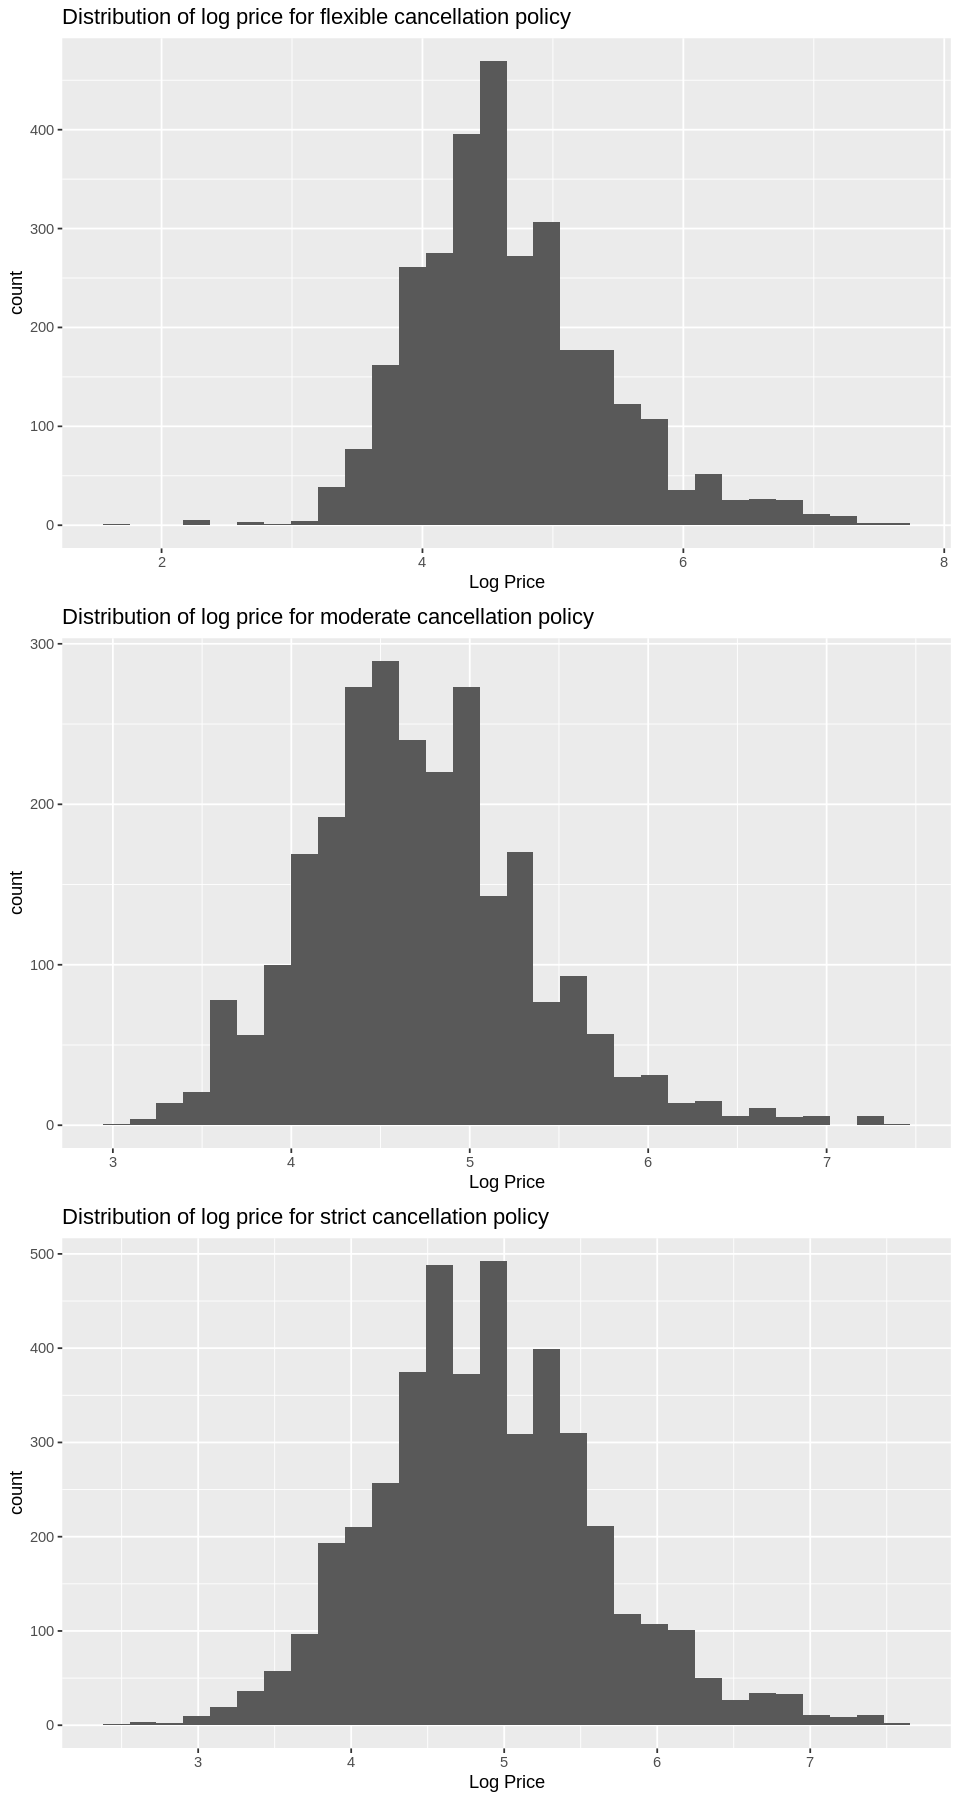

In [97]:
flex <- Airbnb_fil |>
filter(cancellation_policy == "moderate")

anova_dist_flex <- Airbnb_fil |>
filter(cancellation_policy == "flexible") |>
ggplot(aes(x = log_price)) +
geom_histogram() +
labs(x = "Log Price", title = "Distribution of log price for flexible cancellation policy")

anova_dist_mod <- Airbnb_fil |>
filter(cancellation_policy == "moderate") |>
ggplot(aes(x = log_price)) +
geom_histogram() +
labs(x = "Log Price", title = "Distribution of log price for moderate cancellation policy")

anova_dist_str <- Airbnb_fil |>
filter(cancellation_policy == "strict") |>
ggplot(aes(x = log_price)) +
geom_histogram() +
labs(x = "Log Price", title = "Distribution of log price for strict cancellation policy")

options(repr.plot.width = 8, repr.plot.height = 15)
grid.arrange(anova_dist_flex, anova_dist_mod, anova_dist_str, ncol = 1)

Figure 3: Distributions of log prices across three levels of cancellation policies

Before we calculate our results, we take a moment to acknowledge the possible errors of this hypothesis test. Either Type I error or Type II error could occur; Type I error in this context means that we conclude that at least one of the mean prices are different from the others when in fact the mean prices are equal. Type II error in this context means that we conclude that all the mean prices are equal when in fact they are not all equal.

Considering the possible effects of this test, it is hard for us to determine which one of these two errors we should avoid at the cost of the other, because we believe that either error would likely affect people in a roughly equal way and they should not be any serious hazards to human lives.

In [98]:
# ANOVA
anova_results <- 
    aov(log_price ~ cancellation_policy, data = Airbnb_fil) %>% 
    tidy()
print("Table 9: Result of ANOVA") 
anova_results

[1] "Table 9: Result of ANOVA"


term,df,sumsq,meansq,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cancellation_policy,2,98.83322,49.4166121,97.36096,1.329602e-42
Residuals,9984,5067.48749,0.5075608,NA,NA


As the Table 9 shows, since p-value is smaller than 0.05, we reject the null hypothesis and we conclude that at least one mean log price is different from the others. 

Our conclusion lends itself to possible Type I error: since we rejected the null hypothesis, it is possible that the mean prices between cancellation policies are in fact the same when we conclude the opposite. 

## Discussion
Based on our analysis, we found that there is a statistically significant difference between the mean log prices of House-type and Apartment-type listings on Airbnb. The results suggest that the population mean log price for house listings is greater than that for apartment listings. Furthermore, our ANOVA test found a significant difference in at least one of the three mean log prices between the three most common cancellation policies.

We observed that a bootstrap-based approach and a theoretical approach using t-distribution gave the same conclusion in our setting given the same significance level of 5%. This is an assuring result, since these two methods are testing the same hypothesis and thus should produce approximately the same results. However, we also observed that the confidence intervals from the two approaches are completely different. The confidence interval from the t-test is [0.004512368, $\infty$], while the one from bootstrapping is [0.000372762, 0.07812131]. This difference is likely due to the different underlying distributions of the two approaches. For example, the confidence intervals from the theoretical approach are always symmetric around point estimates, but the one via bootstrap distribution is constructed using percentiles so it is not guaranteed to be symmetrical. Additionally, the bootstrap distribution is fixed if and only if our seed value for randomness is fixed, so the obtained bootstrap-based confidence interval is just one instance of all possible confidence intervals from different values of seeds. These are a few possible reasons why the two approaches do not perfectly match, so more rigorous analysis should be conducted in the future with more knowledge.

These findings have significant implications for both hosts and guests on Airbnb. For hosts, knowing the factors that influence pricing can help them maximize their listing prices and enhance their listings' competitiveness. Also, this information could be useful for guests to identify the best lodging alternatives based on their tastes and budget.

Our analysis supported our initial expectations, which were that property types and cancellation policies would have a significant influence on the log pricing of Airbnb listings. Prospective researchers might want to further investigate the relationship between price and season, location, and ratings of both the property and the renter. Factors of a hotel or an apartment's surroundings, such as safety, environment quality, and tourist attractions, could also affect pricing of Airbnb listings with varying property types and cancellation policies, providing an intriguing topic for future exploration. 

Our results may pique the interest of Airbnb management companies, which could lead to further, more economically-oriented inquiries towards helping Airbnb hosts and managers set prices and cancellation policies. We could also potentially provide insights to real estate investors, leading more research in the direction of real estate, helping potential Airbnb hosts decide whether choosing to rent out a house or apartment would be more rewarding. These results could prompt further investigation into smarter decision making for Airbnb customers, helping them decide between houses or apartments, what kinds of cancellation policy is more suitable for them, and define a reasonable price for an Airbnb given its location, amenities, cancellation policy, and other factors.


## References
Airbnb price prediction. www.kaggle.com. [accessed 2023 Mar 18]. https://www.kaggle.com/datasets/stevezhenghp/airbnb-price-prediction?resource=download.

Barron K, Kung E, Proserpio D. 2020. The Effect of Home-Sharing on House Prices and Rents: Evidence from Airbnb. Marketing Science. 40(1). doi:https://doi.org/10.1287/mksc.2020.1227.

Cheng M, Foley C. 2018. The sharing economy and digital discrimination: The case of Airbnb. International Journal of Hospitality Management. 70:95–98. doi:https://doi.org/10.1016/j.ijhm.2017.11.002.

Garcia-López M-À, Jofre-Monseny J, Martínez-Mazza R, Segú M. 2020. Do short-term rental platforms affect housing markets? Evidence from Airbnb in Barcelona. Journal of Urban Economics. 119:103278. doi:https://doi.org/10.1016/j.jue.2020.103278. https://www.sciencedirect.com/science/article/pii/S0094119020300498.

Guttentag DA, Smith SLJ. 2017. Assessing Airbnb as a disruptive innovation relative to hotels: Substitution and comparative performance expectations. International Journal of Hospitality Management. 64:1–10. doi:https://doi.org/10.1016/j.ijhm.2017.02.003. https://www.sciencedirect.com/science/article/pii/S0278431916302250.

Horn K, Merante M. 2017. Is home sharing driving up rents? Evidence from Airbnb in Boston. Journal of Housing Economics. 38:14–24. doi:https://doi.org/10.1016/j.jhe.2017.08.002.

Kwok L, Xie KL. 2018 Oct. Pricing strategies on Airbnb: Are multi-unit hosts revenue pros? International Journal of Hospitality Management. doi:https://doi.org/10.1016/j.ijhm.2018.09.013.

Mody MA, Suess C, Lehto X. 2017. The accommodation experiencescape: a comparative assessment of hotels and Airbnb. International Journal of Contemporary Hospitality Management. 29(9):2377–2404. doi:https://doi.org/10.1108/ijchm-09-2016-0501.

Wachsmuth D, Weisler A. 2018. Airbnb and the rent gap: Gentrification through the sharing economy. Environment and Planning A: Economy and Space. 50(6):1147–1170. doi:https://doi.org/10.1177/0308518x18778038.

ZERVAS G, PROSERPIO D, BYERS JW. 2017. The Rise of the Sharing Economy: Estimating the Impact of Airbnb on the Hotel Industry. Journal of Marketing Research. 54(5):687–705. https://www.jstor.org/stable/44878526.